# Grover SAT Solution
This is based on the work by g. Nanncini in the following paper: https://arxiv.org/abs/1708.03684



In [75]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import PhaseOracle


def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    """Circuit that computes the black-box function from f_in to f_out.

    Create a circuit that verifies whether a given exactly-1 3-SAT
    formula is satisfied by the input. The exactly-1 version
    requires exactly one literal out of every clause to be satisfied.
    """
    num_clauses = len(exactly_1_3_sat_formula)
    
    # This loop will build all the clauses 
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
        circuit.barrier()
        
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    # This will flip f_out in the event that all the auxhillary qubits are true.
    # This completes the oracle
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')    
    circuit.barrier()

    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.

    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
        circuit.barrier()
    

def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)



#Carries out the U_s Oracle
def inversion_about_average(circuit, f_in, n):
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    
    # Count of the Z controls is defined by the count of Qubits, 
    # ie the amount of literals
    circuit.barrier(range(n))
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    circuit.barrier(range(n))
    
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    circuit.barrier()
    
def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
    circuit.barrier()

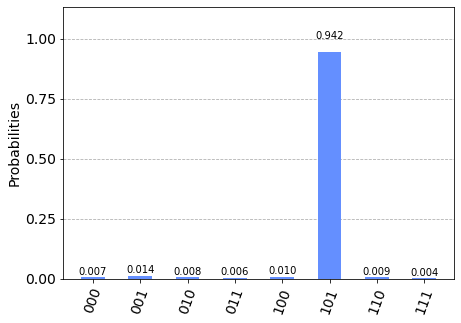

In [76]:

# Make a quantum program for the n-bit Grover search.
n = 3

"""
Exactly-1 3-SAT formula to be satisfied, in conjunctive
normal form. We represent literals with integers, positive or
negative, to indicate a Boolean variable or its negation
"""

exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define the Circuit that the gates will be written to]
grover = QuantumCircuit()


# Input register that holds the Qubits that will do the calculation
f_in = QuantumRegister(n)
grover.add_register(f_in)

# Output Register that holds the output that is discarded due to phase Kickback
f_out = QuantumRegister(1)
grover.add_register(f_out)

# Auxillary Qubits to save results to as 
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)
grover.add_register(aux)

# Define classical register to save the result to in the end
ans = ClassicalRegister(n)
grover.add_register(ans)



# Puts the Qubits in their initial superposition
input_state(grover, f_in, f_out, n)

# T can be mathematically determined beforehand. 
T = 2

# applies U_f and U_s T times.
for t in range(T):
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)
    grover.barrier()

# Measure the output register in the computational basis
for j in range(n):
    grover.measure(f_in[j], ans[j])

# Execute circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute([grover], backend=backend, shots=1000)
result = job.result()

# Get counts and plot histogram
counts = result.get_counts(grover)
plot_histogram(counts)

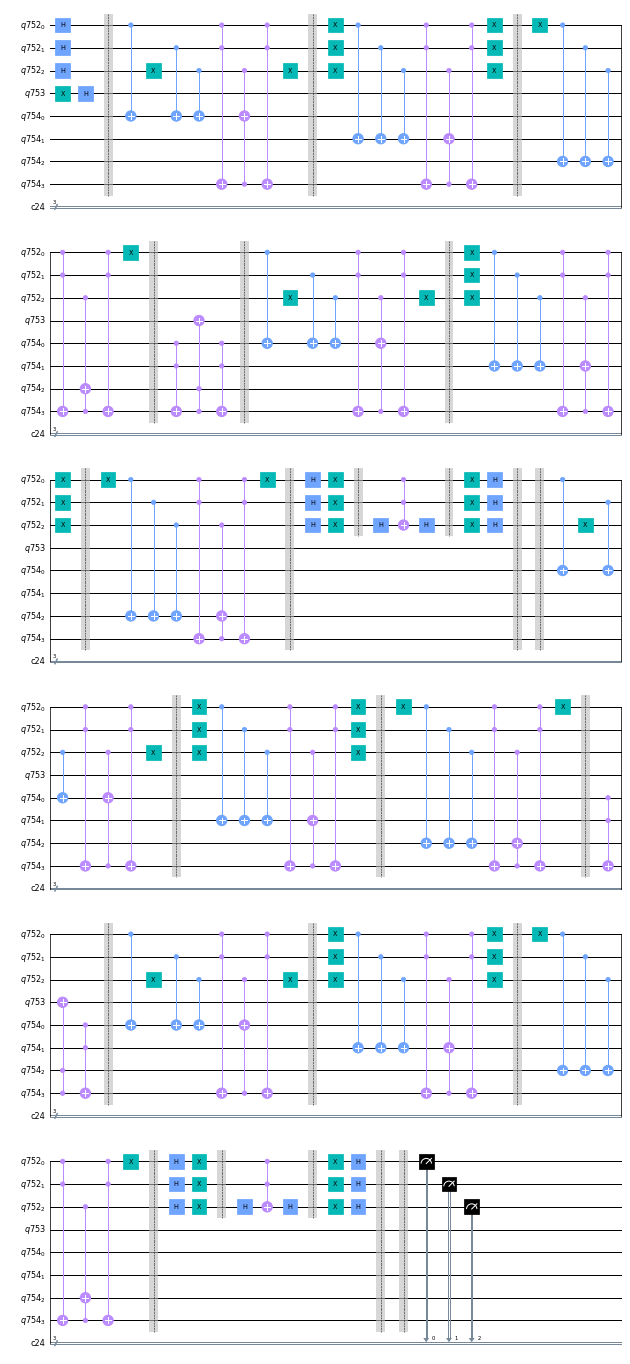

In [79]:
grover.draw(output='mpl', scale=0.5)